## Import Packages And Define Functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

#### Import TALib Only If Necessary

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4420    0  4420    0     0  20896      0 --:--:-- --:--:-- --:--:-- 20947
100  517k  100  517k    0     0  1153k      0 --:--:-- --:--:-- --:--:-- 1153k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4384    0  4384    0     0  20517      0 --:--:-- --:--:-- --:--:-- 20582
100  392k  100  392k    0     0   804k      0 --:--:-- --:--:-- --:--:--  804k


In [ ]:
def annual_num_transaction(position):
    return sum(np.where(position != position.shift(1), 1, 0)) / len(position) * 252.

def annual_return(returns):
    return returns.mean() * 252.

def annual_volatility(returns):
    return returns.std() * (252. ** 0.5)

def cum_return(returns):
    return list(np.exp(returns.cumsum()))[-1]

def max_drawdown(returns):
    cum_returns = np.exp(returns.cumsum())
    cum_max = cum_returns.cummax()
    return ((cum_max - cum_returns) / cum_max).max()

def information_ratio(strategy_return, benchmark_return):
    track_error = annual_volatility(strategy_return - benchmark_return)
    if track_error < 1e-9:
        return 0.
    else:
        return (annual_return(strategy_return) - annual_return(benchmark_return)) / track_error

## Data Cleaning

In [ ]:
!pip install yfinance
import yfinance as yf

In [ ]:
code = [
    "^GSPC",
    "AAPL",
    "JPM",
    "GOOGL",
    "000300.SS", #HS300
    "600887.SS", #YLGF
    "600519.SS", #GZMT
    "600897.SS", #XMKG
    "601601.SS", #ZGTB
    "600188.SS", #YKNY
    "601318.SS", #ZGPA
    "600900.SS", #CJDL
    "600000.SS", #PFYH
    "002460.SZ", #GFLY
    "002033.SZ", #LJGF
]
data_train = yf.download("600887.SS", start = "2007-01-01", end = "2023-01-01", auto_adjust = False)
data_train["close"] = data_train["Adj Close"]
data_train["open"] = data_train["Open"]
data_train["high"] = data_train["High"]
data_train["low"] = data_train["Low"]
data_train["return"] = np.log(data_train["close"] / data_train["close"].shift(1))
data_test = yf.download("600887.SS", start = "2022-01-01", auto_adjust = False)
data_test["close"] = data_test["Adj Close"]
data_test["open"] = data_test["Open"]
data_test["high"] = data_test["High"]
data_test["low"] = data_test["Low"]
data_test["return"] = np.log(data_test["close"] / data_test["close"].shift(1))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Strategy

In [ ]:
windows = [5, 14, 30, 60, 120]
trend_up_stds = [0.5, 1.0, 1.5, 2.0]
trend_down_stds = [0.5, 1.0, 1.5, 2.0]
revert_up_stds = [1.0, 2.0, 4.0, 8.0]
revert_down_stds = [1.0, 2.0, 4.0, 8.0]
transaction_cost = 0.
# max history data needed
look_back_window = 365
# backtest for 24 months
backtest_length = 365 * 2
backtest_launch_points = [
    "2007-12-31",
    "2009-12-31",
    "2011-12-31",
    "2013-12-31",
    "2016-12-31",
    "2019-12-31",
    "2021-12-31",
    ]
performance = pd.DataFrame(columns = ["window",
                                      "trend_up_std",
                                      "trend_down_std",
                                      "revert_up_std",
                                      "revert_down_std",
                                      "launch_point",
                                      "num_transaction_per_year",
                                      "annual_return",
                                      "annual_vol",
                                      "cum_return",
                                      "max_drawdown",
                                      "information_ratio"
                                      ])
for launch_point in backtest_launch_points:
    new_row = pd.DataFrame({
        "window": 0,
        "trend_up_std": 0,
        "trend_down_std": 0,
        "revert_up_std": 0,
        "revert_down_std": 0,
        "launch_point": launch_point,
        "num_transaction_per_year": 0,
        "annual_return": annual_return(data_train[pd.to_datetime(launch_point):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]["return"]),
        "annual_vol": annual_volatility(data_train[pd.to_datetime(launch_point):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]["return"]),
        "cum_return": cum_return(data_train[pd.to_datetime(launch_point):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]["return"]),
        "max_drawdown": max_drawdown(data_train[pd.to_datetime(launch_point):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]["return"]),
        "information_ratio": 0
        }, index = [0])
    performance = pd.concat([performance, new_row], ignore_index = True)

In [ ]:
def bollinger(window, trend_up_std, trend_down_std, revert_up_std, revert_down_std, df, launch_point, look_back_window, backtest_length, launch_position):
    dataframe = df.copy(deep = True)
    dataframe = dataframe[(pd.to_datetime(launch_point) - pd.to_timedelta(look_back_window, unit = "d")):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]
    dataframe[f"position_strategy"] = launch_position
    dataframe[f"SMA"] = dataframe[f"close"].rolling(window).mean()
    dataframe[f"std"] = dataframe[f"close"].rolling(window).std()
    # set index to be 0, 1, 2, ...
    dataframe["date"] = dataframe.index
    dataframe.index = range(len(dataframe))
    # for static stop loss
    open_price = 0.
    # when launch point is not a business day
    while len(dataframe[dataframe["date"] == launch_point].index.values) == 0:
        launch_point = str(pd.to_datetime(launch_point) + pd.to_timedelta(1, unit = "d"))
    launch_point_index = dataframe[dataframe["date"] == launch_point].index.values[0]
    # add extra row for forecast purpose
    last_date = pd.to_datetime(dataframe.loc[len(dataframe) - 1, "date"])
    dataframe.loc[len(dataframe), "date"] = last_date + pd.to_timedelta(1, unit = "d")
    # strategy logic
    for i in range(launch_point_index + 1, len(dataframe)):
        if dataframe.loc[i - 1, f"position_strategy"] == 0:
            if (dataframe.loc[i - 1, f"close"] > dataframe.loc[i - 1, f"SMA"] + trend_up_std * dataframe.loc[i - 1, f"std"])\
            | (dataframe.loc[i - 1, f"close"] < dataframe.loc[i - 1, f"SMA"] - (trend_down_std + revert_down_std) * dataframe.loc[i - 1, f"std"]):
                dataframe.loc[i, f"position_strategy"] = 1
                open_price = dataframe.loc[i, "open"]
            else:
                dataframe.loc[i, f"position_strategy"] = dataframe.loc[i - 1, f"position_strategy"]
        else:
            if (dataframe.loc[i - 1, f"close"] < dataframe.loc[i - 1, f"SMA"] - trend_down_std * dataframe.loc[i - 1, f"std"])\
            | (dataframe.loc[i - 1, f"close"] > dataframe.loc[i - 1, f"SMA"] + (trend_up_std + revert_up_std) * dataframe.loc[i - 1, f"std"])\
            | (((dataframe.loc[i - 1, f"close"] -  dataframe.loc[i - 2, f"close"]) / dataframe.loc[i - 2, f"close"]) < -0.05)\
            | (((dataframe.loc[i - 1, f"close"] -  dataframe.loc[i - 6, f"close"]) / dataframe.loc[i - 6, f"close"]) < -0.3):
                dataframe.loc[i, f"position_strategy"] = 0
                open_price = 0.
            else:
                dataframe.loc[i, f"position_strategy"] = dataframe.loc[i - 1, f"position_strategy"]
    dataframe[f"return_strategy"] = dataframe[f"position_strategy"] * dataframe["return"]
    # set index back to date
    dataframe.set_index("date", inplace = True)
    dataframe_drop = dataframe[(pd.to_datetime(launch_point) + pd.to_timedelta(1, unit = "d")):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]
    return dataframe_drop

## Train

In [ ]:
for window in windows:
    for trend_up_std in trend_up_stds:
        for trend_down_std in trend_down_stds:
            for revert_up_std in revert_up_stds:
                for revert_down_std in revert_down_stds:
                    for launch_point in backtest_launch_points:
                        output_train = bollinger(window, trend_up_std, trend_down_std, revert_up_std, revert_down_std, data_train, launch_point, look_back_window, backtest_length, 0)
                        # drop the added last row
                        output_train = output_train.dropna()
                        new_row = pd.DataFrame({
                            "window": window,
                            "trend_up_std": trend_up_std,
                            "trend_down_std": trend_down_std,
                            "revert_up_std": revert_up_std,
                            "revert_down_std": revert_down_std,
                            "launch_point": launch_point,
                            "num_transaction_per_year": annual_num_transaction(output_train[f"position_strategy"]),
                            "annual_return": annual_return(output_train[f"return_strategy"]),
                            "annual_vol": annual_volatility(output_train[f"return_strategy"]),
                            "cum_return": cum_return(output_train[f"return_strategy"]),
                            "max_drawdown": max_drawdown(output_train[f"return_strategy"]),
                            "information_ratio": information_ratio(output_train[f"return_strategy"], output_train["return"])
                        }, index = [0])
                        performance = pd.concat([performance, new_row], ignore_index = True)

In [ ]:
# calculate average information ration through all bt launch points
tmp = pd.DataFrame(columns = ["window",
                              "trend_up_std",
                              "trend_down_std",
                              "revert_up_std",
                              "revert_down_std",
                              "avg_information_ratio"
                              ])
for window in windows:
    for trend_up_std in trend_up_stds:
        for trend_down_std in trend_down_stds:
            for revert_up_std in revert_up_stds:
                for revert_down_std in revert_down_stds:
                    new_row = pd.DataFrame({
                        "window": window,
                        "trend_up_std": trend_up_std,
                        "trend_down_std": trend_down_std,
                        "revert_up_std": revert_up_std,
                        "revert_down_std": revert_down_std,
                        "avg_information_ratio": performance[(performance["window"] == window) &
                        (performance["trend_up_std"] == trend_up_std) &
                        (performance["trend_down_std"] == trend_down_std) &
                        (performance["revert_up_std"] == revert_up_std) &
                        (performance["revert_down_std"] == revert_down_std)][["information_ratio"]].mean().values[0]
                        }, index = [0])
                    tmp = pd.concat([tmp, new_row], ignore_index = True)
performance = pd.merge(performance, tmp, on = ["window", "trend_up_std", "trend_down_std", "revert_up_std", "revert_down_std"], how = "left")

In [ ]:
performance.sort_values(by = ["avg_information_ratio", "window", "trend_up_std", "trend_down_std", "revert_up_std", "revert_down_std", "launch_point"], ascending = False)

,window,trend_up_std,trend_down_std,revert_up_std,revert_down_std,launch_point,num_transaction_per_year,annual_return,annual_vol,cum_return,max_drawdown,information_ratio,avg_information_ratio
13,60,1.0,0.5,2.0,1.0,2021-12-31,76.016529,0.047718,0.116083,1.046891,0.073212,1.275683,0.272802
12,60,1.0,0.5,2.0,1.0,2019-12-31,34.812371,0.208027,0.272473,1.492377,0.205089,0.144402,0.272802
11,60,1.0,0.5,2.0,1.0,2016-12-31,32.666667,0.280311,0.243713,1.717037,0.193498,0.481952,0.272802
10,60,1.0,0.5,2.0,1.0,2013-12-31,49.472393,0.153492,0.277359,1.346956,0.231753,0.038897,0.272802
9,60,1.0,0.5,2.0,1.0,2011-12-31,38.40501,0.284910,0.287237,1.718677,0.245722,-0.407155,0.272802
8,60,1.0,0.5,2.0,1.0,2009-12-31,34.669405,0.208367,0.287850,1.495826,0.187992,-0.070958,0.272802
7,60,1.0,0.5,2.0,1.0,2007-12-31,41.827869,0.179422,0.367018,1.415457,0.511715,0.446789,0.272802
6,0,0,0,0,0,2021-12-31,0,-0.272470,0.278796,0.768942,0.379037,0,NaN
5,0,0,0,0,0,2019-12-31,0,0.177190,0.352342,1.407372,0.378439,0,NaN
4,0,0,0,0,0,2016-12-31,0,0.164908,0.345070,1.375326,0.392722,0,NaN


## Backtest

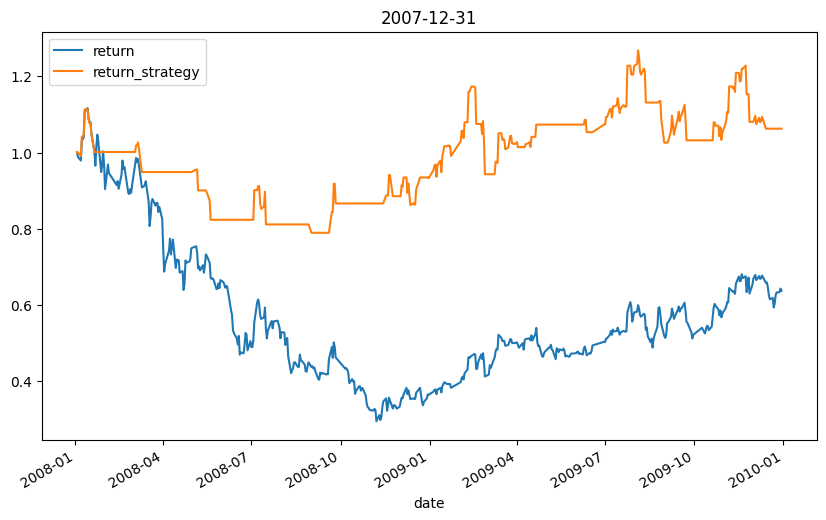

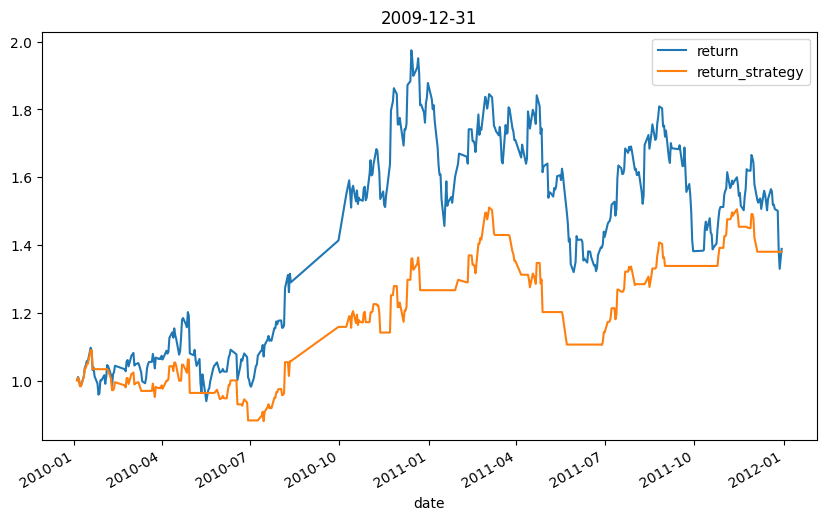

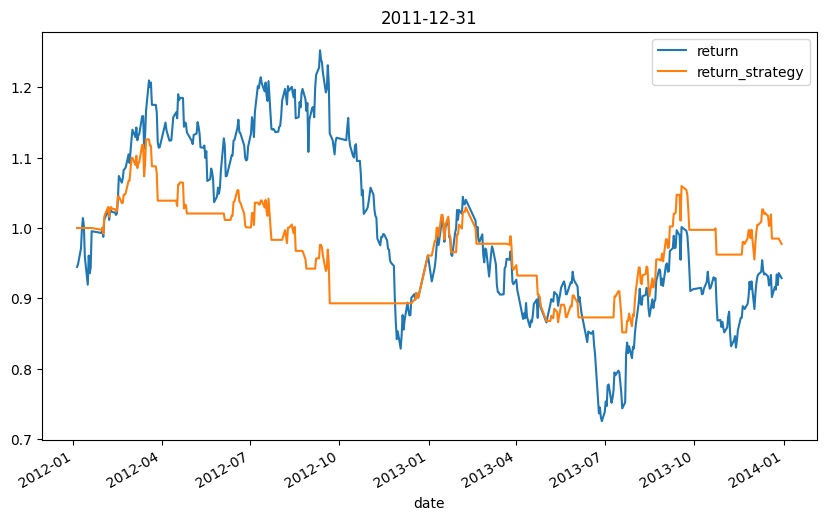

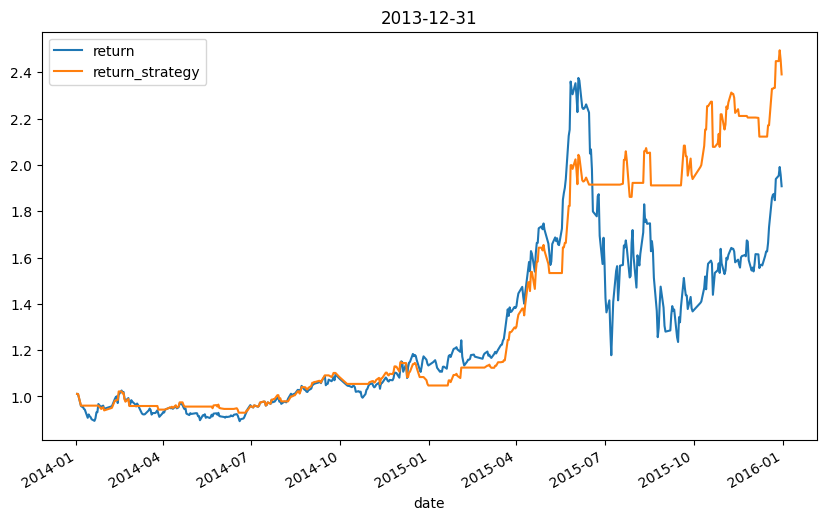

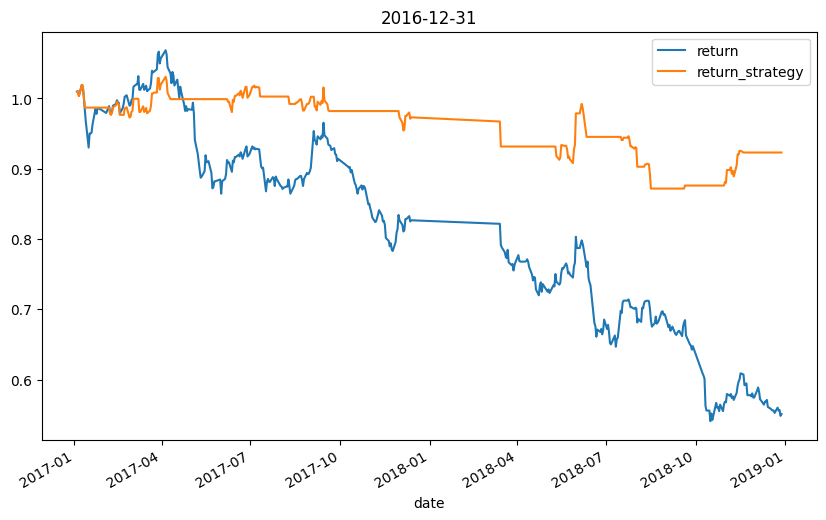

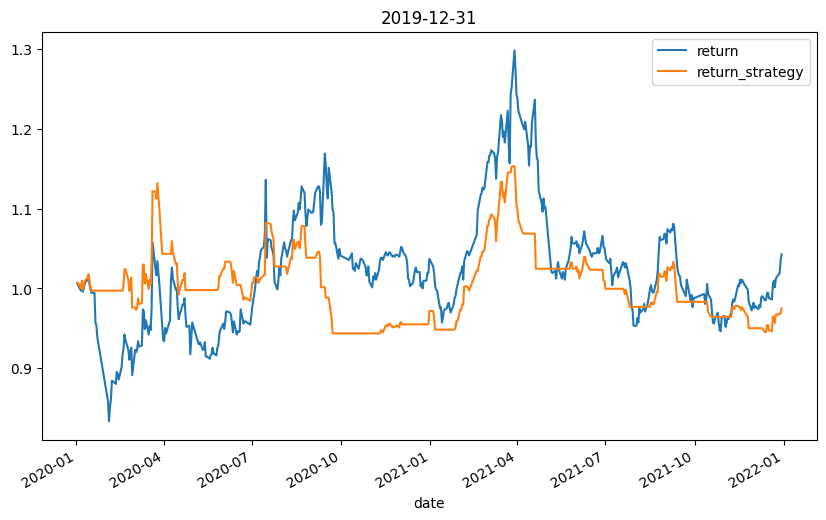

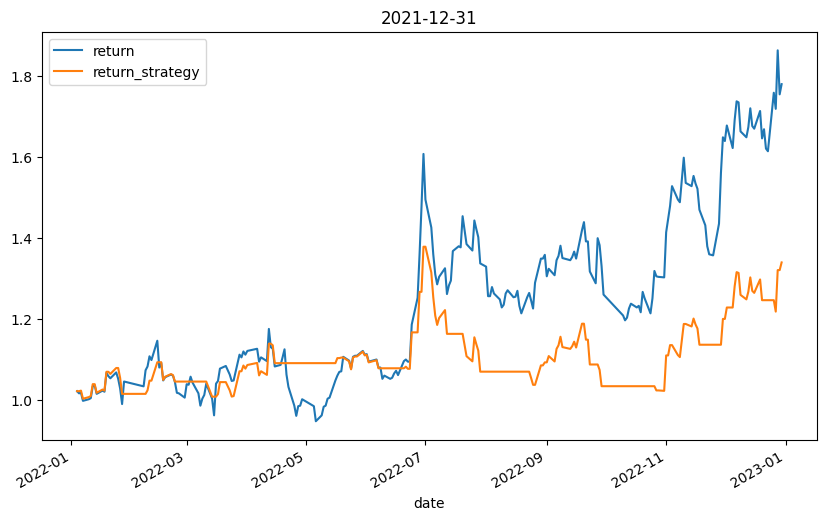

In [ ]:
# window, trend_up_std, trend_down_std, revert_up_std, revert_down_std = 120, 1.0, 2.0, 4.0, 1.0 #GSPC
# window, trend_up_std, trend_down_std, revert_up_std, revert_down_std = 30, 1.0, 0.5, 8.0, 1.0 #GFLY
# window, trend_up_std, trend_down_std, revert_up_std, revert_down_std = 60, 1.0, 0.5, 2.0, 1.0 #YLGF
window, trend_up_std, trend_down_std, revert_up_std, revert_down_std = 14, 0.5, 0.5, 1.0, 4.0 #LJGF
for launch_point in backtest_launch_points:
    output_backtest = bollinger(window, trend_up_std, trend_down_std, revert_up_std, revert_down_std, data_train, launch_point, look_back_window, backtest_length, 0)
    # drop the added last row
    output_backtest = output_backtest.dropna()
    output_backtest[["return", f"return_strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 6), title = launch_point)
    # output_backtest[["open_price"]].plot(figsize=(10, 6))
    # output_backtest[f"position_strategy"].plot(secondary_y = True, legend = "position")
    # output_backtest[["close"]].plot(secondary_y = True, legend = "close")

## Forecast

In [ ]:
# window, trend_up_std, trend_down_std, revert_up_std, revert_down_std = 120, 1.0, 2.0, 4.0, 1.0 #GSPC
# window, trend_up_std, trend_down_std, revert_up_std, revert_down_std = 30, 1.0, 0.5, 8.0, 1.0 #GFLY
# window, trend_up_std, trend_down_std, revert_up_std, revert_down_std = 60, 1.0, 0.5, 2.0, 1.0 #YLGF
window, trend_up_std, trend_down_std, revert_up_std, revert_down_std = 14, 0.5, 0.5, 1.0, 4.0 #LJGF
# launch_point = "2023-01-01"
# launch_point = "2024-03-19" #^GSPC
# launch_point = "2024-03-06" #YLGF
# launch_point = "2024-03-19" #GFLY
launch_point = "2024-03-14" #LJGF
output_test = bollinger(window, trend_up_std, trend_down_std, revert_up_std, revert_down_std, data_test, launch_point, look_back_window, backtest_length, 0)
new_row = {
    "window": window,
    "trend_up_std": trend_up_std,
    "trend_down_std": trend_down_std,
    "revert_up_std": revert_up_std,
    "revert_down_std": revert_down_std,
    "launch_point": launch_point,
    "num_transaction_per_year": annual_num_transaction(output_test[f"position_strategy"]),
    "annual_return": annual_return(output_test[f"return_strategy"]),
    "annual_vol": annual_volatility(output_test[f"return_strategy"]),
    "cum_return": cum_return(output_test[f"return_strategy"]),
    "max_drawdown": max_drawdown(output_test[f"return_strategy"]),
    "information_ratio": information_ratio(output_test[f"return_strategy"], output_test["return"])
}

In [ ]:
new_row

{'window': 14,
 'trend_up_std': 0.5,
 'trend_down_std': 0.5,
 'revert_up_std': 1.0,
 'revert_down_std': 4.0,
 'launch_point': '2024-03-14',
 'num_transaction_per_year': 36.0,
 'annual_return': -1.0467831550031876,
 'annual_vol': 0.1990640732894989,
 'cum_return': nan,
 'max_drawdown': 0.024615384615384487,
 'information_ratio': 0.0}

<Axes: >

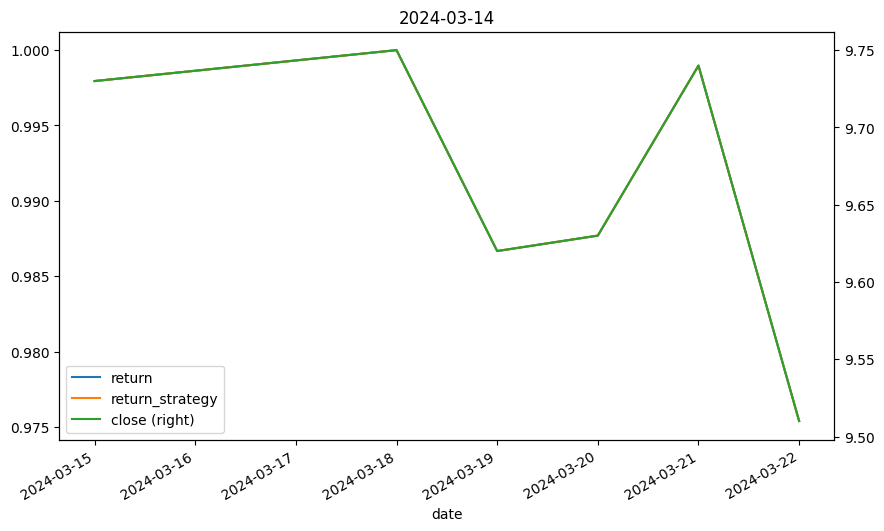

In [ ]:
output_test[["return", f"return_strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 6), title = launch_point)
# output_test[["close", f"SMA_{short_term}", f"SMA_{long_term}"]].plot(figsize=(10, 6))
# output_test[f"position_strategy"].plot(secondary_y = True, legend = "position")
output_test["close"].plot(secondary_y = True, legend = "close")

In [ ]:
output_test.tail(10)

,open,close,high,low,volume,code,return,position_strategy,SMA,std,return_strategy
date,,,,,,,,,,,
2024-03-15,9.78,9.73,9.88,9.61,302193.0,002033,-0.002053,1.0,9.301429,0.290539,-0.002053
2024-03-18,9.73,9.75,9.80,9.66,265941.0,002033,0.002053,1.0,9.335714,0.313926,0.002053
2024-03-19,9.77,9.62,9.77,9.58,241918.0,002033,-0.013423,1.0,9.390000,0.290146,-0.013423
2024-03-20,9.63,9.63,9.71,9.60,173519.0,002033,0.001039,1.0,9.435714,0.272134,0.001039
2024-03-21,9.63,9.74,9.83,9.58,248980.0,002033,0.011358,1.0,9.492857,0.242406,0.011358
2024-03-22,9.70,9.51,9.74,9.46,201997.0,002033,-0.023897,1.0,9.530714,0.192372,-0.023897
2024-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
